Consider the problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) = \frac{1}{2}m\omega^2x^2
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $l = 10$, $\hbar = 1, m = 1 $ and $\omega = 1$

In [118]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy


torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

#!pip install pyDOE
from pyDOE import lhs #latin hypercube sampling

cuda
NVIDIA RTX A6000


In [119]:
#The sine activation function
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Automatic differentiation in pytorch
def dfx(f, x):
  grads = []
  for i in range(f.shape[1]):  # Loop over each column
      gouts = torch.zeros_like(f)
      gouts[:, i] = 1.0  # Differentiate w.r.t. one column at a time
      df_i = grad([f], [x], grad_outputs=gouts, create_graph=True)[0]
      grads.append(df_i)  # Collect gradients for each column

  return torch.stack(grads, dim=-1)

In [120]:
#Defining the hyperparameters
t0 =-5; tf = 5; xbc = 0; eig_num = 5; gauss_num = 20
col_pts = 50;  layers = [1,512,512,256,256,128,gauss_num] #This is layer structure for the pretrained model
lr = 1e-4; epochs =10000

In [121]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  f = ((1-torch.exp(-(t - t0)))*(1-torch.exp(t - tf))).view(-1,1)
  psi_hat = bound + f*N1 #Broadcasting is done here
  return psi_hat

In [122]:
def hamEqs_Loss(t,psi,v):
    psi_x = dfx(psi,t).squeeze(1)
    psi_xx = dfx(psi_x,t).squeeze(1)
    E  = torch.sum(psi* (-0.5*psi_xx + psi*v), dim = 0)/torch.sum(psi * psi, dim = 0) #The eigenvalues
    L = (psi_xx) + (E-v)*psi
    return L,E

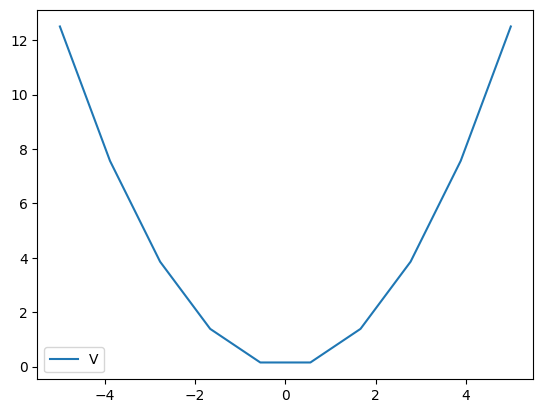

In [123]:
#Defining the potential well
def V(x):
    y = 0.5*x**2
    return y
x = torch.linspace(t0,tf,10).view(-1,1)
pot = V(x)
#scaled_pot = V_norm(x)

plt.plot(x,pot, label='V')
#plt.plot(x,scaled_pot, label='V_norm')
plt.legend()
plt.show()

In [ ]:
#Defining the Frobenius norm
def frobenius_norm(G):
  I = torch.eye(G.shape[0], device = device, dtype = G.dtype)
  loss = torch.linalg.matrix_norm(G - I) #The frobenius norm
  return loss

#Defining the monotonicity_penalty
def monotonicity_penalty(E, margin = 0.0):
  diffs = E[:-1] - E[1:] + margin
  penalty = torch.relu(diffs).sum()
  return penalty

#Defining the cosine matrix using trapezoidal rule
def cosine_matrix(psi,x):
  x_sorted, indices = torch.sort(x, dim=0)
  psi_sorted = psi[indices, :]  # Reorder psi to match x
  psi_norm = torch.sqrt(torch.trapz(psi_sorted**2, x_sorted, dim=0))  # (k,)
  psi_normalized = psi_norm / psi_norm  # (n, k)
  psi_prod = psi_normalized.unsqueeze(2) * psi_normalized.unsqueeze(1)  # (n, k, k)
  cos_matrix = torch.trapz(psi_prod, x_sorted, dim=0)
  return cos_matrix

In [133]:
y = torch.randn(10,5); t = torch.linspace(-5,5,10).float()
torch.sqrt(torch.trapz(y**2, t, dim = 0))

tensor([3.0152, 2.4108, 3.6341, 3.0195, 4.8054])

In [126]:
class pre_trainerclass(torch.nn.Module):
  def __init__(self,layers):
    super(pre_trainerclass,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #z = self.batch_norms[i](z)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [127]:
# Freeze for feature extraction, or fine-tune
class transferred_model(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.activation = sine()
        self.features_list = pretrained_model.linears[:-1]  # all layers except last
        self.new_head1 = nn.Linear(128, 64)
        self.new_head2 = nn.Linear(64, eig_num)

    def forward(self, t):
        for layer in self.features_list:
            t = self.activation(layer(t))
        a1 = self.new_head1(self.activation(t))
        return self.new_head2(a1)


##### Now we need to load the trained model weights for transfer learning then train for our problem

In [128]:
gaussian_model = pre_trainerclass(layers) #holder to initialize the pre-trained model weights

#The checkpoint
checkpoint = torch.load('checkpoints/pre_trainer_no_ortho.pth')

gaussian_model.load_state_dict(checkpoint['model_state_dict'])  #Load the weights into the holder
gaussian_model.eval() #Set to evaluation
transfer_model = transferred_model(gaussian_model) #Transfer the model

In [129]:
#Now we initialize the model without freezing the pretrained weights
transfer_model.to(device)
print(transfer_model)
betas = [0.999, 0.9999]
optimizer = optim.Adam(transfer_model.parameters(), lr=lr, betas=betas)

transferred_model(
  (activation): sine()
  (features_list): ModuleList(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (new_head1): Linear(in_features=128, out_features=64, bias=True)
  (new_head2): Linear(in_features=64, out_features=5, bias=True)
)


In [130]:
def nn_train(NN,t0,tf,xbc,epochs,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist','cos_loss_hist','total_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  #t_rand = t[torch.randperm(t.shape[0])].to(device).float() #Reshuffling the collocation points
  t_rand = t.to(device).float()
  t_rand.requires_grad =True

  #Dictionary to store the final training
  dic = {}

  stime = time.time()
  for iter in range(epochs + 1):
    loss = 0.0
    vx = V(t_rand)

    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,t0,tf,xbc).to(device) #The forward pass

    L,En = hamEqs_Loss(t_rand,psi,vx)
    En_history.append(En.cpu().detach().numpy())
    Loss = torch.nn.MSELoss()
    criteria_loss = 300.0*Loss(L,torch.zeros_like(L)) #The scaled pde_loss
    #Getting the loss after the forward pass
    loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())

    #The attention or Grams Matrix (actually the cosine matrix)
    G = cosine_matrix(psi, t_rand)
    lossG = 10.0*frobenius_norm(G)
    loss_dic['cos_loss_hist'].append(lossG.cpu().detach().numpy().item())

    #The eigenvalue loss
    #loss_eig = monotonicity_penalty(En, 0.1)

    total_loss = criteria_loss + lossG #+ loss_eig



    if iter % 200 == 0:
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]}')
      print('--------------------------------------------')
      print('Total_loss: ',total_loss.cpu().detach().numpy())


    #Backward propagation
    optimizer.zero_grad()
    total_loss.backward()
    #Introducing Gradient clipping
    #max_norm =12.0
    #torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm)
    optimizer.step()
    loss += total_loss.cpu().detach().numpy()


    #Storing the loss after each iteration
    loss_dic['total_loss_hist'].append(loss)


  #Storing the final eigenfunction and eigenvalue
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [131]:
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()
x_lhs.shape

torch.Size([50, 1])

In [132]:
Loss, eig_vals, qPINN = nn_train(transfer_model,t0,tf,xbc,epochs, x_lhs)

RuntimeError: The size of tensor a (49) must match the size of tensor b (0) at non-singleton dimension 0

In [ ]:
tTest = torch.linspace(t0,tf,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi = parametricSolutions(tTest,qPINN[1].cpu(),t0,tf,xbc).data.numpy()

<>:23: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_34556\392424421.py:23: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\psi(x)$', color='black')


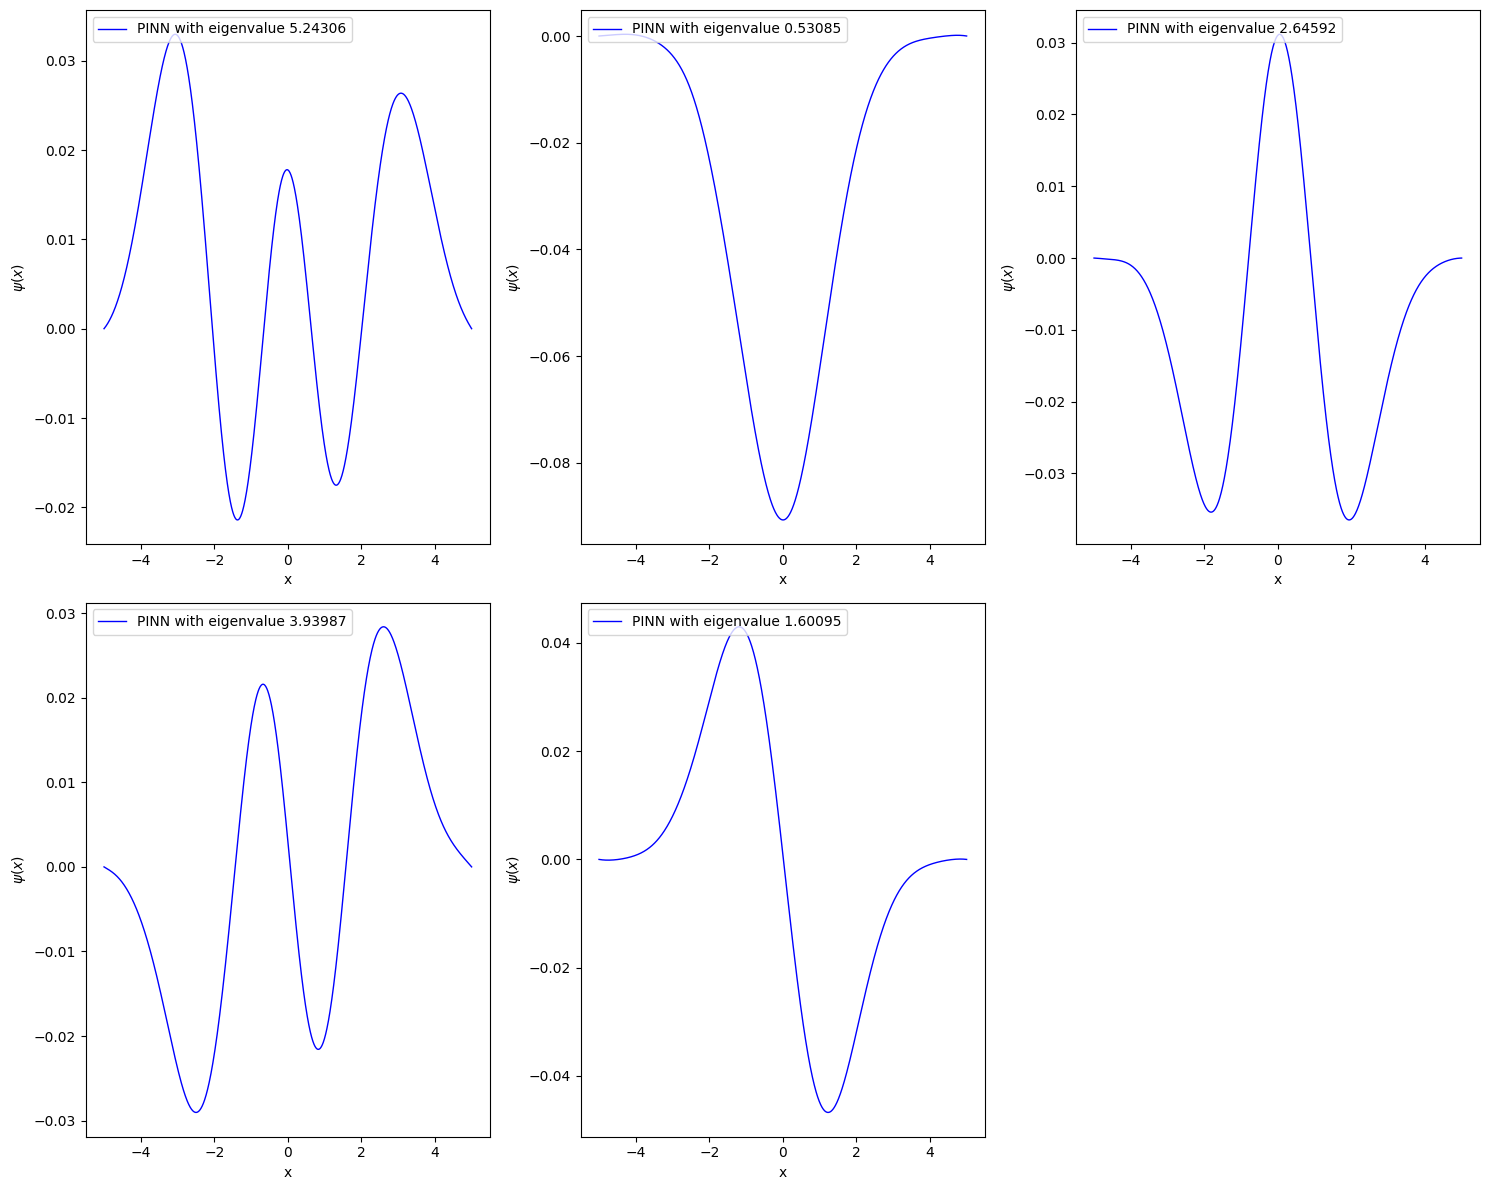

In [ ]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eig_vals[-1,:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    ax.plot(t_net, psi[:,index], color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_vals[-1,index]:.5f}')
    #ax.plot(t_net, V(torch.tensor(t_net)))
    #ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

In [ ]:
G = psi.T @ psi
G

array([[ 3.4521180e-01,  1.5072096e-03,  3.9963052e-04,  7.3982775e-04,
        -2.2280253e-03],
       [ 1.5072096e-03,  2.0653400e+00, -2.4839798e-03,  2.7612383e-03,
         3.6519007e-03],
       [ 3.9963052e-04, -2.4839798e-03,  4.8905441e-01,  1.0621808e-03,
        -1.9471813e-04],
       [ 7.3982775e-04,  2.7612383e-03,  1.0621808e-03,  3.3653134e-01,
        -7.3784962e-04],
       [-2.2280253e-03,  3.6519007e-03, -1.9471813e-04, -7.3784962e-04,
         6.9387168e-01]], dtype=float32)